## **Note!**

Make sure you install pygame in your terminal: \
pip install pygame

## **Prototype 6 - Heap Visualization**

In [ ]:
import pygame
import sys
import random
import heapq
import math
from collections import deque

# Constants
WIDTH, HEIGHT = 1200, 800
CELL_SIZE = 20
ROWS = HEIGHT // CELL_SIZE
COLS = (WIDTH - 450) // CELL_SIZE  # Wider sidebar for tree visualization

# Colors
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)
YELLOW = (255, 255, 0)
PURPLE = (128, 0, 128)
GRAY = (200, 200, 200)
ORANGE = (255, 165, 0)
CYAN = (0, 255, 255)

def generate_maze(rows, cols):
    """Generate a random maze using depth-first search"""
    maze = [[1 for _ in range(cols)] for _ in range(rows)]
    start = (random.randint(0, rows-1), random.randint(0, cols-1))
    end = start
    while end == start:
        end = (random.randint(0, rows-1), random.randint(0, cols-1))

    stack = [start]
    maze[start[0]][start[1]] = 0
    directions = [(-1,0),(1,0),(0,-1),(0,1)]

    while stack:
        current = stack[-1]
        neighbors = []
        for dx, dy in directions:
            nx, ny = current[0]+dx*2, current[1]+dy*2
            if 0 <= nx < rows and 0 <= ny < cols and maze[nx][ny] == 1:
                neighbors.append((nx, ny))

        if neighbors:
            next_cell = random.choice(neighbors)
            wall = (current[0]+(next_cell[0]-current[0])//2,
                    current[1]+(next_cell[1]-current[1])//2)
            maze[wall[0]][wall[1]] = 0
            maze[next_cell[0]][next_cell[1]] = 0
            stack.append(next_cell)
        else:
            stack.pop()

    # Add some random passages
    for _ in range(rows * cols // 4):
        x, y = random.randint(0, rows-1), random.randint(0, cols-1)
        maze[x][y] = 0

    return maze, start, end

def astar(maze, start, end):
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = { (r, c): float('inf') for r in range(ROWS) for c in range(COLS) }
    g_score[start] = 0
    f_score = { (r, c): float('inf') for r in range(ROWS) for c in range(COLS) }
    f_score[start] = heuristic(start, end)

    # For visualization
    open_set_history = []
    current_history = []
    operation_history = []

    while open_set:
        current_f, current = heapq.heappop(open_set)
        operation_history.append(("pop", current_f, current))
        open_set_history.append([item for item in open_set])  # Take snapshot
        current_history.append(current)

        if current == end:
            return reconstruct_path(came_from, current), open_set_history, current_history, operation_history

        for neighbor in get_neighbors(maze, current):
            tentative_g = g_score[current] + 1
            if tentative_g < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g
                new_f = tentative_g + heuristic(neighbor, end)
                f_score[neighbor] = new_f
                heapq.heappush(open_set, (new_f, neighbor))
                operation_history.append(("push", new_f, neighbor))
                open_set_history.append([item for item in open_set])  # Snapshot after push
                current_history.append(current)

    return None, open_set_history, current_history, operation_history

def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def get_neighbors(maze, pos):
    neighbors = []
    for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
        nx, ny = pos[0]+dx, pos[1]+dy
        if 0 <= nx < ROWS and 0 <= ny < COLS:
            if maze[nx][ny] == 0:
                neighbors.append((nx, ny))
    return neighbors

def reconstruct_path(came_from, current):
    path = [current]
    while current in came_from:
        current = came_from[current]
        path.append(current)
    return path[::-1]

def draw_heap_tree(screen, heap, current_pos, step, max_steps):
    panel_width = 450
    panel_height = HEIGHT

    # Draw background
    pygame.draw.rect(screen, GRAY, (0, 0, panel_width, panel_height))

    # Title and info
    font = pygame.font.SysFont(None, 30)
    title = font.render("Min-Heap Tree Visualization", True, BLACK)
    screen.blit(title, (10, 10))

    step_text = font.render(f"Step {step}/{max_steps}", True, BLACK)
    screen.blit(step_text, (10, 50))

    current_text = font.render(f"Current: {current_pos}", True, PURPLE)
    screen.blit(current_text, (10, 90))

    if not heap:
        empty_text = font.render("Heap is empty", True, RED)
        screen.blit(empty_text, (10, 130))
        return

    # Tree drawing parameters
    node_radius = 20
    level_height = 100
    start_x = panel_width // 2
    start_y = 150

    # Calculate tree structure
    tree_nodes = []
    for i in range(len(heap)):
        f, pos = heap[i]
        parent = (i-1) // 2 if i > 0 else -1
        tree_nodes.append({
            'value': f"{pos}\nf={f:.1f}",
            'pos': None,
            'parent': parent,
            'index': i,
            'heap_pos': (f, pos)
        })

    # Calculate node positions
    for i, node in enumerate(tree_nodes):
        level = math.floor(math.log2(i+1)) if i > 0 else 0
        nodes_in_level = i - (2**level - 1)
        max_nodes_in_level = 2**level
        spacing = (panel_width * 0.8) / (max_nodes_in_level + 1)
        x = spacing * (nodes_in_level + 1)
        y = start_y + level * level_height
        node['pos'] = (x, y)

    # Draw connections first (so nodes appear on top)
    for node in tree_nodes:
        if node['parent'] >= 0:
            parent_pos = tree_nodes[node['parent']]['pos']
            pygame.draw.line(screen, BLACK, parent_pos, node['pos'], 2)

    # Draw nodes
    for node in tree_nodes:
        x, y = node['pos']
        # Color root orange, others blue
        color = ORANGE if node['index'] == 0 else BLUE
        pygame.draw.circle(screen, color, (int(x), int(y)), node_radius)

        # Draw text (position and f-score)
        lines = node['value'].split('\n')
        value_font = pygame.font.SysFont(None, 18)
        for i, line in enumerate(lines):
            text = value_font.render(line, True, WHITE)
            text_rect = text.get_rect(center=(int(x), int(y) - 5 + i * 15))
            screen.blit(text, text_rect)

    # Draw heap array representation at bottom
    array_y = start_y + (math.floor(math.log2(len(heap))) * level_height + 120)
    array_title = font.render("Heap Array:", True, BLACK)
    screen.blit(array_title, (10, array_y))

    for i, (f, pos) in enumerate(heap):
        node_text = font.render(f"{pos} (f={f:.1f})", True, RED if i == 0 else BLACK)
        screen.blit(node_text, (20 + (i % 3) * 140, array_y + 40 + (i // 3) * 30))

# Pygame setup
pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("A* Pathfinding with Heap Tree Visualization")

# Generate initial maze and path
maze, start, end = generate_maze(ROWS, COLS)
path, open_set_history, current_history, operation_history = astar(maze, start, end)

# Ensure valid path exists
while not path:
    maze, start, end = generate_maze(ROWS, COLS)
    path, open_set_history, current_history, operation_history = astar(maze, start, end)

path_index = 0
visualization_step = 0
paused = True  # Start paused to examine initial state

# Main loop
clock = pygame.time.Clock()
running = True

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.KEYDOWN:
            if event.key == pygame.K_r:  # Regenerate maze
                maze, start, end = generate_maze(ROWS, COLS)
                path, open_set_history, current_history, operation_history = astar(maze, start, end)
                while not path:
                    maze, start, end = generate_maze(ROWS, COLS)
                    path, open_set_history, current_history, operation_history = astar(maze, start, end)
                path_index = 0
                visualization_step = 0
            elif event.key == pygame.K_SPACE:  # Pause/resume
                paused = not paused
            elif event.key == pygame.K_LEFT and (paused or visualization_step > 0):  # Step back
                visualization_step = max(0, visualization_step - 1)
            elif event.key == pygame.K_RIGHT and (paused or visualization_step < len(current_history)-1):  # Step forward
                visualization_step = min(len(current_history)-1, visualization_step + 1)

    if not paused and visualization_step < len(current_history)-1:
        visualization_step += 1

    screen.fill(WHITE)

    # Draw maze background
    for r in range(ROWS):
        for c in range(COLS):
            if maze[r][c] == 1:
                pygame.draw.rect(screen, BLACK,
                               (450 + c*CELL_SIZE, r*CELL_SIZE, CELL_SIZE, CELL_SIZE))

    # Highlight visited nodes
    visited = set()
    for i in range(visualization_step):
        visited.add(current_history[i])
    for v in visited:
        pygame.draw.rect(screen, YELLOW,
                         (450 + v[1]*CELL_SIZE, v[0]*CELL_SIZE, CELL_SIZE, CELL_SIZE))

    # Highlight open set nodes (frontier)
    if visualization_step < len(open_set_history):
        for f, pos in open_set_history[visualization_step]:
            pygame.draw.rect(screen, CYAN,
                             (450 + pos[1]*CELL_SIZE, pos[0]*CELL_SIZE, CELL_SIZE, CELL_SIZE))

    # Highlight current node
    if visualization_step < len(current_history):
        current_pos = current_history[visualization_step]
        pygame.draw.rect(screen, PURPLE,
                         (450 + current_pos[1]*CELL_SIZE, current_pos[0]*CELL_SIZE, CELL_SIZE, CELL_SIZE))

    # Draw the path if it's been found by this step
    if path and visualization_step >= len(current_history)-1:
        for node in path:
            pygame.draw.rect(screen, RED,
                         (450 + node[1]*CELL_SIZE, node[0]*CELL_SIZE, CELL_SIZE, CELL_SIZE))

    # Draw start and end
    pygame.draw.rect(screen, GREEN,
                   (450 + start[1]*CELL_SIZE, start[0]*CELL_SIZE, CELL_SIZE, CELL_SIZE))
    pygame.draw.rect(screen, BLUE,
                   (450 + end[1]*CELL_SIZE, end[0]*CELL_SIZE, CELL_SIZE, CELL_SIZE))

    # Draw heap tree visualization
    if visualization_step < len(open_set_history):
        current_heap = open_set_history[visualization_step]
        current_pos = current_history[visualization_step]
        draw_heap_tree(screen, current_heap, current_pos, visualization_step+1, len(current_history))

    # Draw instructions
    # font = pygame.font.SysFont(None, 24)
    # instructions = [
    #     "Controls:",
    #     "R - Regenerate maze",
    #     "SPACE - Pause/Resume",
    #     "LEFT/RIGHT - Step through algorithm",
    #     "",
    #     "Heap Visualization:",
    #     "Orange: Root node (min element)",
    #     "Blue: Other nodes in heap",
    #     "Lines: Parent-child relationships",
    #     "",
    #     "Maze Visualization:",
    #     "YELLOW - Visited nodes",
    #     "CYAN - Nodes in open set (frontier)",
    #     "PURPLE - Current expanding node",
    #     "GREEN - Start",
    #     "BLUE - Goal"
    # ]
    # for i, line in enumerate(instructions):
    #     text = font.render(line, True, BLACK)
    #     screen.blit(text, (10, HEIGHT - 250 + i * 20))

    pygame.display.flip()
    clock.tick(5 if not paused else 60)

pygame.quit()
sys.exit()


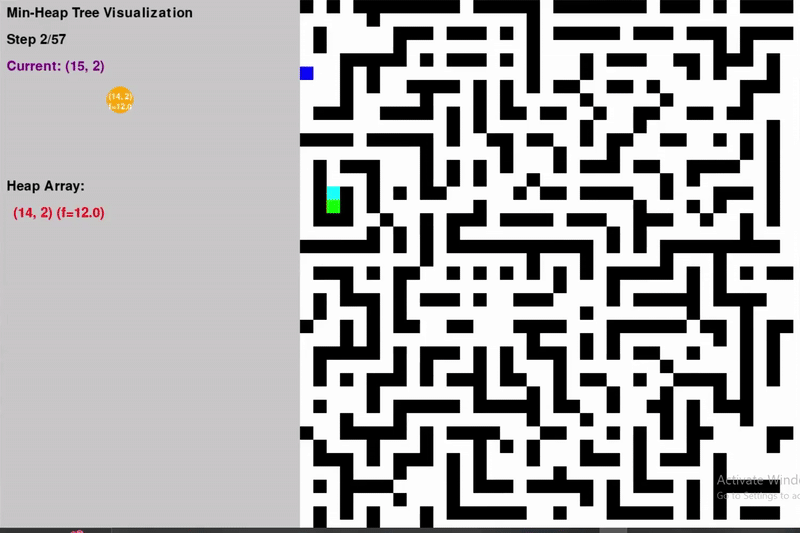